In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import os

In [3]:
os.chdir('/SGRNJ06/randd/USER/zhouyiqi/work/analysis/space/dataset24_1')

In [22]:
matrix_dir = Path("raw")  # 表达矩阵目录
spatial_dir = Path("spatial")                    # spatial 文件夹
output_file = "dataset1-bc24-spatial.h5ad" 

In [5]:
adata = sc.read_10x_mtx(matrix_dir, var_names='gene_symbols', make_unique=True)

In [6]:
print(f"表达矩阵维度: {adata.shape}")

表达矩阵维度: (576, 32589)


In [7]:
# ==== Step 2: 读取空间位置信息 ====
# tissue_positions_list.csv: barcode,in_tissue,array_row,array_col,pixel_x,pixel_y
pos_file = spatial_dir / "tissue_positions_list.csv"
positions = pd.read_csv(pos_file, header=None)
positions.columns = ["barcode", "in_tissue", "array_row", "array_col", "pxl_col_in_fullres", "pxl_row_in_fullres"]

# 保证 barcode 顺序和表达矩阵一致
positions = positions.set_index("barcode").loc[adata.obs_names]

# 保存坐标到 adata
adata.obs = pd.concat([adata.obs, positions], axis=1)
adata.obsm["spatial"] = positions[["pxl_col_in_fullres", "pxl_row_in_fullres"]].to_numpy()

In [49]:
adata

AnnData object with n_obs × n_vars = 420 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'spatial'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [9]:
# ==== Step 3: 保存 .h5ad 文件 ====
adata.write(output_file)

/SGRNJ/Public/Software/conda_env/dev/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


/SGRNJ/Public/Software/conda_env/dev/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


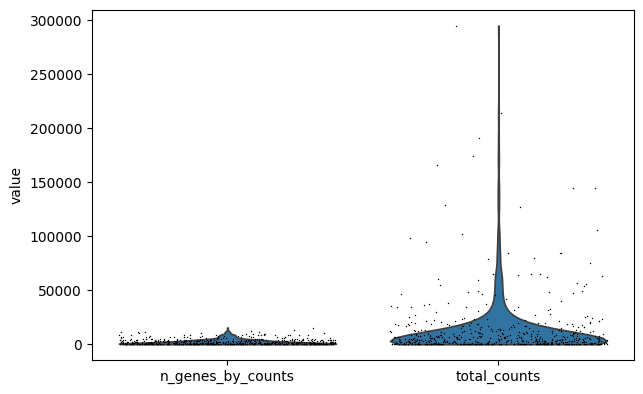

/SGRNJ/Public/Software/conda_env/dev/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


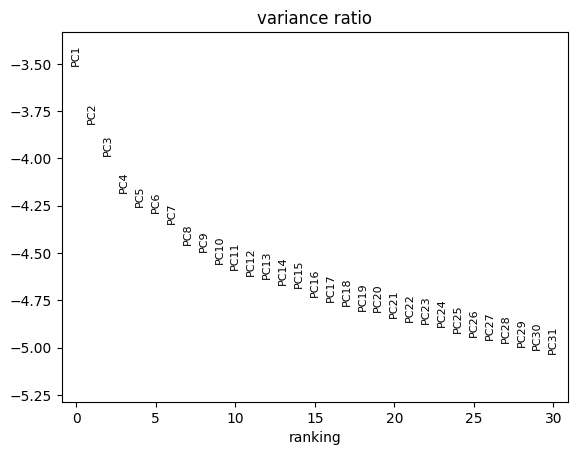

In [11]:

# 基本 QC
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4)

# 过滤低质量 spot / gene
adata = adata[adata.obs.n_genes_by_counts > 200, :]
adata = adata[:, adata.var.n_cells_by_counts > 3]

# 归一化 & log 转换
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# 高变基因
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

# PCA
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True)


/SGRNJ/Public/Software/conda_env/dev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


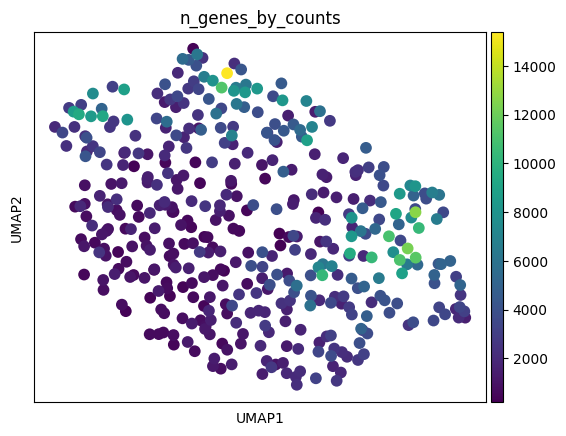

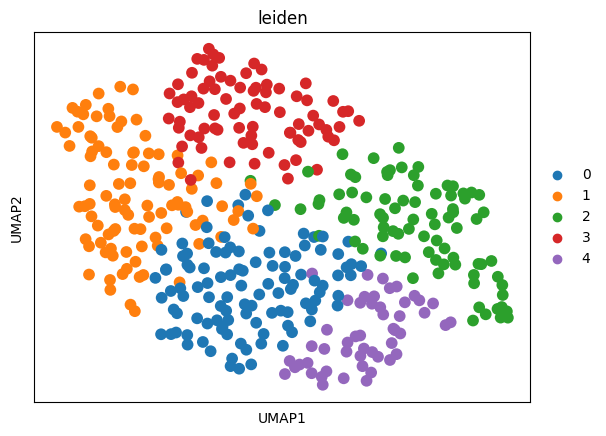

In [12]:
# 构建邻居图
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

# UMAP 可视化
sc.tl.umap(adata)
sc.pl.umap(adata, color='n_genes_by_counts')

# Leiden 聚类
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color='leiden')


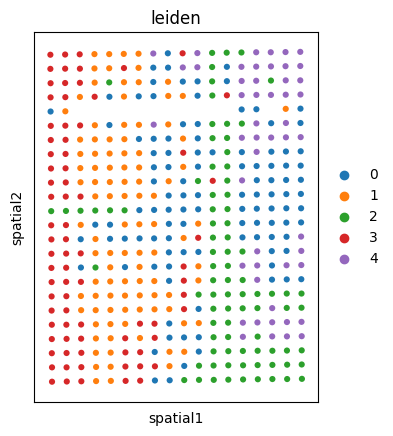

In [16]:
sc.pl.spatial(adata, color='leiden', spot_size=40, img_key=None)

In [37]:
import matplotlib.image as mpimg
import json

sf_file = spatial_dir / "scalefactors_json.json"

with open(sf_file, 'r') as f:
    scalefactors = json.load(f)

hires = mpimg.imread(spatial_dir / "tissue_hires_image.png")
lowres = mpimg.imread(spatial_dir / "tissue_lowres_image.png")
adata.uns['spatial'] = {
    "sample1": {
        "images": {"hires": hires, "lowres": lowres},
        "scalefactors": scalefactors
    }
}

<Figure size 1600x1600 with 0 Axes>

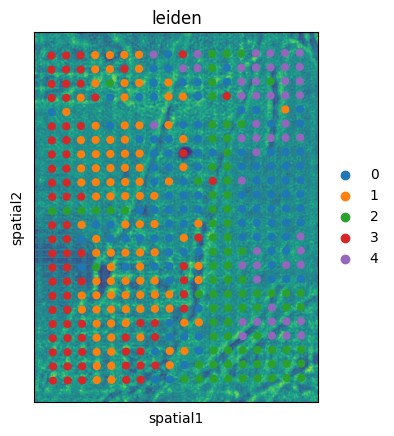

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 16))
sc.pl.spatial(adata, color='leiden', spot_size=40, img_key='hires')

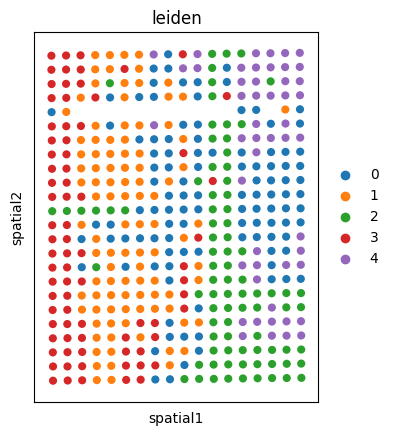

In [32]:
sc.pl.spatial(adata, color='leiden', spot_size=40, img_key=None)

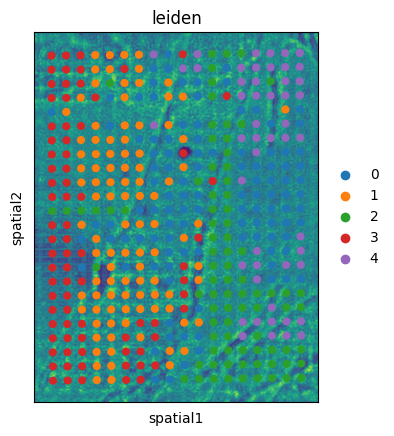

In [38]:
sc.pl.spatial(adata, color='leiden', spot_size=40, img_key='lowres')

In [44]:
from collections import Counter
Counter(adata.obs['array_row'])

Counter({17: 24,
         14: 24,
         13: 24,
         1: 24,
         0: 24,
         16: 24,
         8: 23,
         6: 23,
         11: 23,
         12: 23,
         15: 23,
         2: 23,
         9: 23,
         4: 23,
         10: 23,
         7: 23,
         5: 23,
         3: 23})